In [47]:
# ✅ 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import re

In [48]:
# STEP 1: Upload the ZIP file
from google.colab import files
uploaded = files.upload()

# STEP 2: Unzip the file
import zipfile
import os

# Get the uploaded file name
zip_file = list(uploaded.keys())[0]

# Create a folder to extract into
extract_folder = "extracted_files"
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# STEP 3: Load CSV from extracted folder
import pandas as pd

# List files in the extracted folder to confirm name
extracted = os.listdir(extract_folder)
print("Extracted files:", extracted)

# Assuming there's only one CSV in the zip:
csv_file = [f for f in extracted if f.endswith('.csv')][0]
csv_path = os.path.join(extract_folder, csv_file)

# Load CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
df.head()


Saving College Event Feedback Survey .csv.zip to College Event Feedback Survey .csv (2).zip
Extracted files: ['College Event Feedback Survey .csv']


,Timestamp,Username,1. Full Name,2. Email Address,3. Course and Year,4. Event Name,5. How would you rate the event overall?,6. Would you attend a similar event in the future?,7. What did you like the most about the event?,8. What could be improved in future events?,9. Did you face any challenges during the event?,"10. On a scale of 1–10, how likely are you to recommend this event to a friend?",11. Which part of the event do you think needs more attention next time? [Registration process],11. Which part of the event do you think needs more attention next time? [Time management],11. Which part of the event do you think needs more attention next time? [Anchoring/hosting],11. Which part of the event do you think needs more attention next time? [Activities & games],11. Which part of the event do you think needs more attention next time? [Communication/Announcements],12. Do you have a message for the event organizers?
0,2025/07/31 3:32:43 PM GMT+5:30,Kyunahihorahipdai@gmail.com,Kyu nahi ho rhi padai,Kyunahihorahipdai@gmail.com,Kyu nahi ho rahi pdai,Webinar,1,No,Pdai krne ka time in cheejo main jata hai...,Pdai karo or karne do,Pdai ka time nikl jata h,1,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Bachho se pucho kyu nahi ho rahi pdai
1,2025/07/31 3:34:57 PM GMT+5:30,mrsibbu12345@gmail.com,Aryan,mrsibbu12345@gmail.com,Mca 2nd,Seminar,4,May be,Knowledge,Some activities involvement..that makes semina...,No,8,Excellent,Excellent,Excellent,Excellent,Excellent,No
2,2025/07/31 3:40:07 PM GMT+5:30,kushagrasharma2474@gmail.com,Kushagra Sharma,kushagrasharma2474@gmail.com,MCA 3 Sem,Webinar,4,Yes,Learning Something New,No Improves,NO,9,Excellent,Excellent,Excellent,Excellent,Excellent,NO
3,2025/07/31 3:49:38 PM GMT+5:30,carpedieminact@gmail.com,Saif,carpedieminact@gmail.com,BE and Final year,Webinar,5,Yes,Stability,Could be more Organised,Nope,10,Was Okay,Was Okay,Was Okay,Was Okay,Was Okay,All good.
4,2025/07/31 3:51:45 PM GMT+5:30,Raj.baghel.174656@gmail.com,Raj Baghel,Raj.baghel.174656,B.Tech 2025,Hackathon,5,Yes,Culture,Interactivity,No,10,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Needs Improvementmn 1,Well done


In [52]:
# Clean column names
df.columns = df.columns.str.strip()

# Show column names to verify before proceeding
print(df.columns.tolist())

# Clean string data
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Only proceed if 'Challenges' column exists
if 'Challenges' in df.columns:
    df['Challenges'] = df['Challenges'].str.lower().replace({
        'nope': 'no',
        'no ': 'no',
        'yes ': 'yes',
        'noo': 'no'
    })

# Fill missing values in text columns (check if they exist first)
text_cols = ['Liked Most', 'To Improve', 'Message']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")

# Convert ratings to numeric if present
for rating_col in ['Event Rating', 'Recommend Score']:
    if rating_col in df.columns:
        df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')

# Drop rows with missing ratings
essential_cols = ['Event Rating', 'Recommend Score']
df.dropna(subset=[col for col in essential_cols if col in df.columns], inplace=True)


['Timestamp', 'Username', '1. Full Name', '2. Email Address', '3.  Course and Year', '4. Event Name', '5. How would you rate the event overall?', '6. Would you attend a similar event in the future?', '7. What did you like the most about the event?', '8.  What could be improved in future events?', '9. Did you face any challenges during the event?', '10.  On a scale of 1–10, how likely are you to recommend this event to a friend?', '11.  Which part of the event do you think needs more attention next time?  [Registration process]', '11.  Which part of the event do you think needs more attention next time?  [Time management]', '11.  Which part of the event do you think needs more attention next time?  [Anchoring/hosting]', '11.  Which part of the event do you think needs more attention next time?  [Activities & games]', '11.  Which part of the event do you think needs more attention next time?  [Communication/Announcements]', '12. Do you have a message for the event organizers?']


/tmp/ipython-input-3065454961.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [56]:
df.rename(columns={
    '5. How would you rate the event overall?': 'Event Rating',
    '6. Would you attend a similar event in the future?': 'Attend Again',
    '7. What did you like the most about the event?': 'Liked Most',
    '8. What could be improved in future events?': 'To Improve',
    '9. Did you face any challenges during the event?': 'Challenges',
    '10. On a scale of 1–10, how likely are you to recommend this event to a friend?': 'Recommend Score',
    '12. Do you have a message for the event organizers?': 'Message'
}, inplace=True)


In [57]:
print(df.columns.tolist())


['Timestamp', 'Username', '1. Full Name', '2. Email Address', '3.  Course and Year', '4. Event Name', 'Event Rating', 'Attend Again', 'Liked Most', 'To Improve', 'Challenges', 'Recommend Score', '11.  Which part of the event do you think needs more attention next time?  [Registration process]', '11.  Which part of the event do you think needs more attention next time?  [Time management]', '11.  Which part of the event do you think needs more attention next time?  [Anchoring/hosting]', '11.  Which part of the event do you think needs more attention next time?  [Activities & games]', '11.  Which part of the event do you think needs more attention next time?  [Communication/Announcements]', 'Message']


In [58]:
df.rename(columns={
    '5. How would you rate the event overall?': 'Event Rating',
    '6. Would you attend a similar event in the future?': 'Attend Again',
    '7. What did you like the most about the event?': 'Liked Most',
    '8.  What could be improved in future events?': 'To Improve',  # double space after '8.' may exist
    '9. Did you face any challenges during the event?': 'Challenges',
    '10.  On a scale of 1–10, how likely are you to recommend this event to a friend?': 'Recommend Score',
    '12. Do you have a message for the event organizers?': 'Message'
}, inplace=True)


In [59]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isnull(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity

df['Liked_Sentiment'] = df['Liked Most'].apply(get_sentiment)
df['Improve_Sentiment'] = df['To Improve'].apply(get_sentiment)


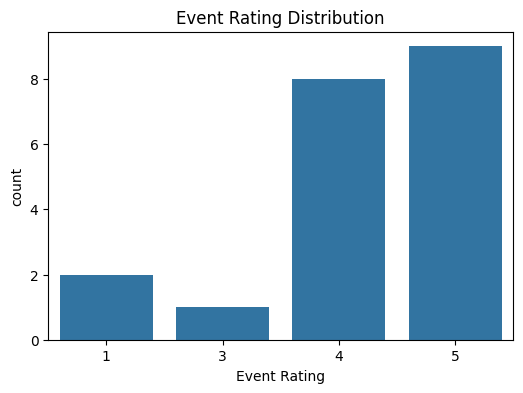

In [60]:
plt.figure(figsize=(6,4))
sns.countplot(x='Event Rating', data=df)
plt.title('Event Rating Distribution')
plt.show()


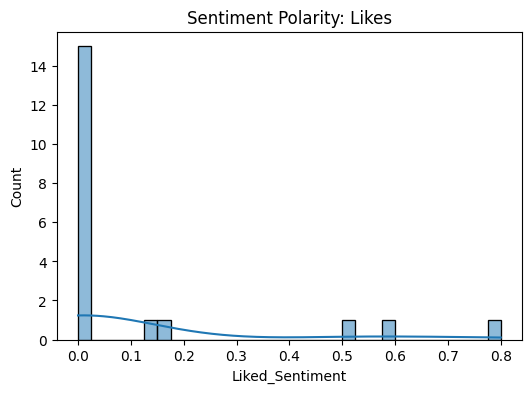

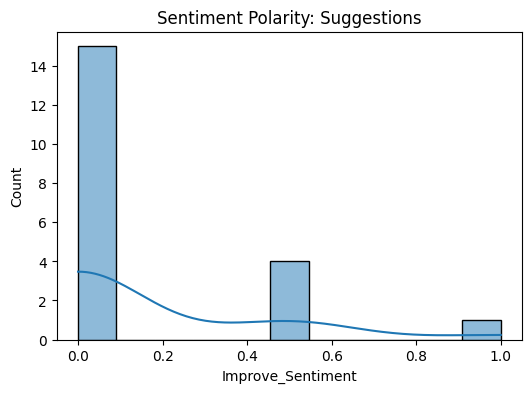

In [61]:
plt.figure(figsize=(6,4))
sns.histplot(df['Liked_Sentiment'], kde=True)
plt.title('Sentiment Polarity: Likes')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['Improve_Sentiment'], kde=True)
plt.title('Sentiment Polarity: Suggestions')
plt.show()


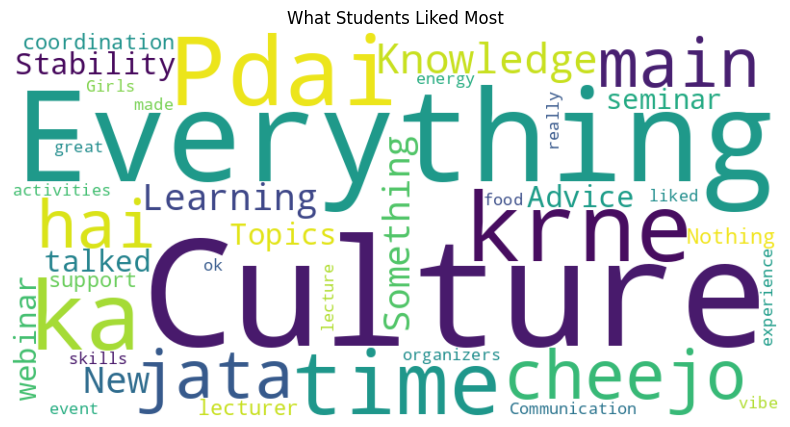

In [62]:
from wordcloud import WordCloud

likes = ' '.join(df['Liked Most'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(likes)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('What Students Liked Most')
plt.show()


/tmp/ipython-input-357124714.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


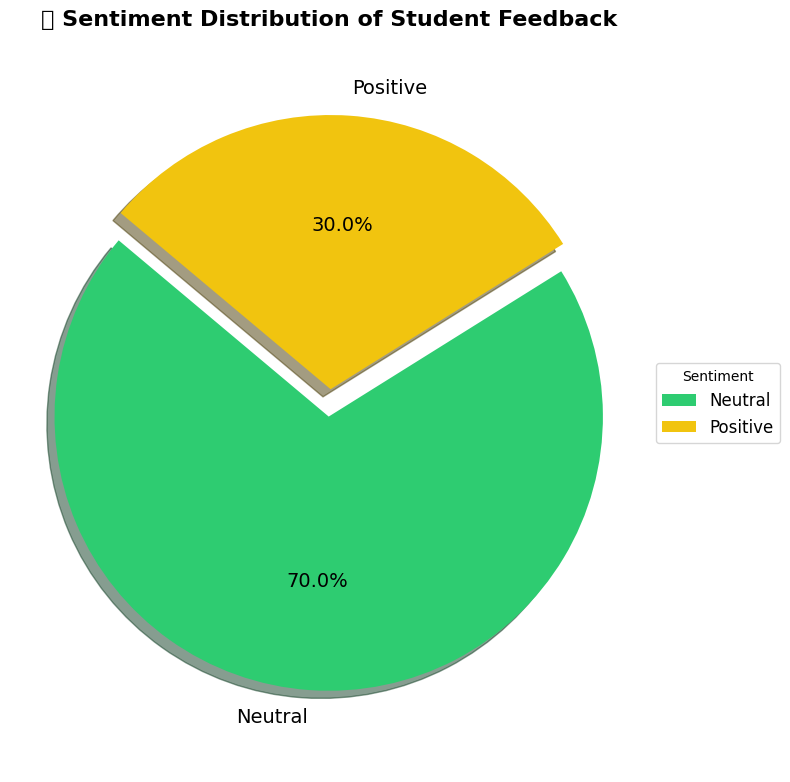

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# 🟢 Step 1: Apply sentiment analysis on the 'Message' column (or 'To Improve', etc.)
def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Set the correct column name for feedback (change if needed)
feedback_column = 'Message'  # or 'To Improve', etc.
df['Sentiment'] = df[feedback_column].apply(get_sentiment)

# 🟢 Step 2: Count sentiments
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

# 🟢 Step 3: Dynamic explode based on number of sentiments present
explode = [0.05] * len(sizes)
colors = ['#2ecc71', '#f1c40f', '#e74c3c'][:len(sizes)]  # Trim to match number of sentiments

# 🟢 Step 4: Plot the customized pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    explode=explode,
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14, 'color': 'black'}
)

# 🟢 Step 5: Add legend and title
plt.legend(wedges, labels, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
plt.title("📊 Sentiment Distribution of Student Feedback", fontsize=16, weight='bold')
plt.axis('equal')  # Ensures pie chart is a circle
plt.tight_layout()
plt.show()


In [23]:
print("🔍 Average Event Rating:", df['Event Rating'].astype(float).mean())
print("🔍 Average Recommend Score:", df['Recommend Score'].astype(float).mean())
print("✅ Most Common Likes:")
print(df['Liked Most'].value_counts().head())
print("\n⚠️ Most Common Suggestions:")
print(df['To Improve'].value_counts().head())


🔍 Average Event Rating: 4.1
🔍 Average Recommend Score: 6.7
✅ Most Common Likes:
Liked Most
Everything                                      2
Knowledge                                       1
Pdai krne ka time in cheejo main jata hai...    1
Learning Something New                          1
Stability                                       1
Name: count, dtype: int64

⚠️ Most Common Suggestions:
To Improve
Nothing                                                       2
Some activities involvement..that makes seminar intersting    1
Pdai karo or karne do                                         1
No Improves                                                   1
Could be more Organised                                       1
Name: count, dtype: int64


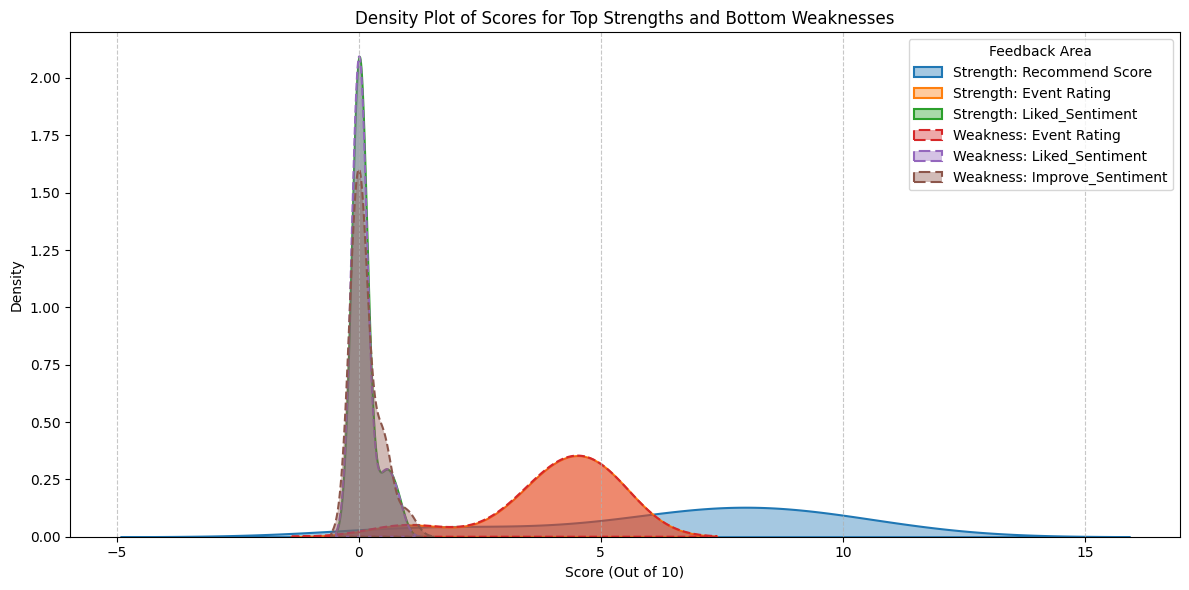

In [36]:
# Again, select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Step 2: Identify top 3 and bottom 3 based on percentage of high scores
top_strengths = high_score_percentage.head(3)
bottom_weaknesses = high_score_percentage.tail(3)

# Step 3: Plot density
plt.figure(figsize=(12, 6))

# Plot top strengths
for col in top_strengths.index:
    sns.kdeplot(numeric_df[col], label=f"Strength: {col}", fill=True, alpha=0.4, bw_adjust=1.2, linewidth=1.5)

# Plot bottom weaknesses
for col in bottom_weaknesses.index:
    sns.kdeplot(numeric_df[col], label=f"Weakness: {col}", fill=True, alpha=0.4, bw_adjust=1.2, linestyle="--", linewidth=1.5)

plt.title('Density Plot of Scores for Top Strengths and Bottom Weaknesses')
plt.xlabel('Score (Out of 10)')
plt.ylabel('Density')
plt.legend(title="Feedback Area", facecolor='white')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3801957632.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_scores.values, y=average_scores.index, palette='coolwarm')


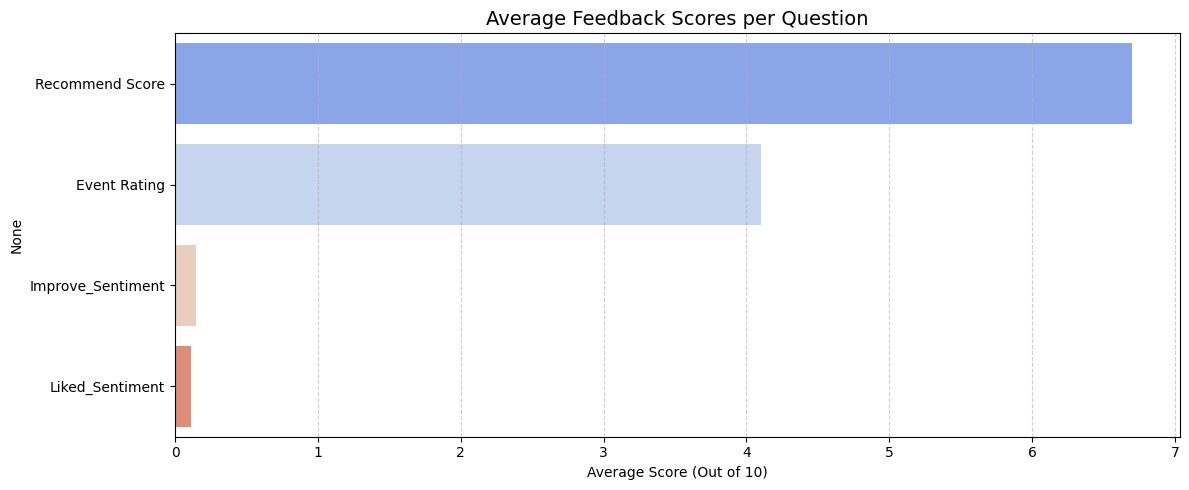

In [37]:
# Average Feedback Scores per Question

average_scores = numeric_df.mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=average_scores.values, y=average_scores.index, palette='coolwarm')
plt.title("Average Feedback Scores per Question", fontsize=14)
plt.xlabel("Average Score (Out of 10)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


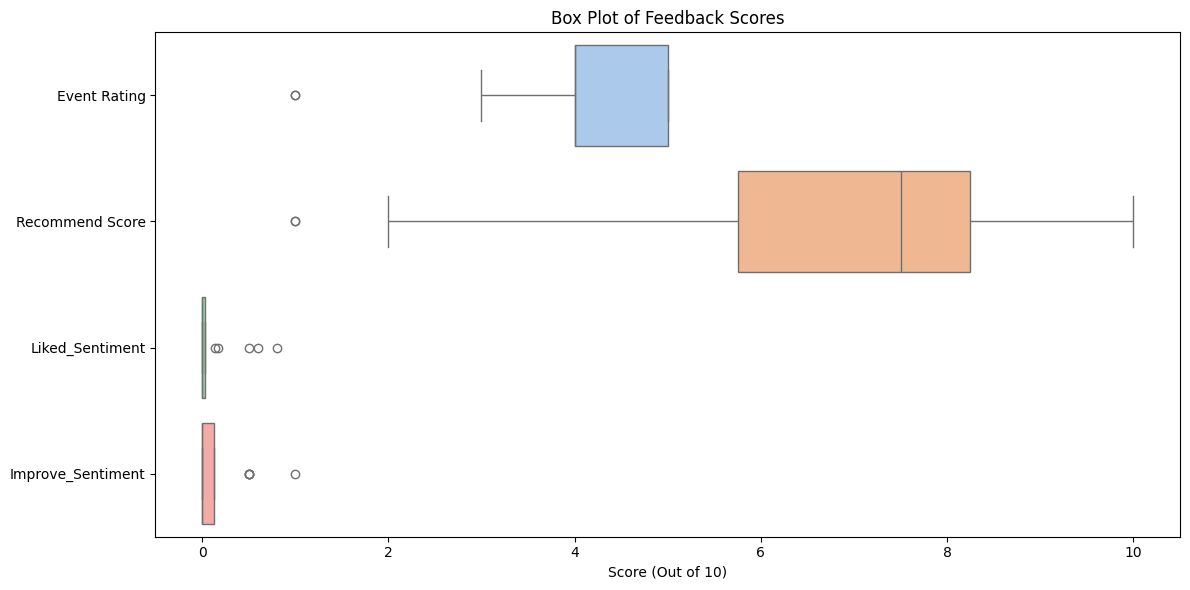

In [39]:
#Correlation Heatmap of Feedback Questions

# Correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df, orient='h', palette='pastel')
plt.title('Box Plot of Feedback Scores')
plt.xlabel('Score (Out of 10)')
plt.tight_layout()
plt.show()



In [40]:
# Optional: Using TextBlob sentiment already calculated
positive_comments = df[df['Liked_Sentiment'] > 0.5]['Liked Most']
negative_comments = df[df['Liked_Sentiment'] < 0]['Liked Most']

from collections import Counter
import re

def extract_keywords(text_series):
    words = " ".join(text_series.dropna()).lower()
    words = re.findall(r'\b[a-z]{4,}\b', words)  # Only words with 4+ letters
    return Counter(words).most_common(10)

print("💚 Top Words from Positive Comments:")
print(extract_keywords(positive_comments))

print("\n💔 Top Words from Negative Comments:")
print(extract_keywords(negative_comments))


💚 Top Words from Positive Comments:
[('coordination', 1), ('support', 1), ('from', 1), ('organizers', 1), ('made', 1), ('great', 1), ('experience', 1), ('really', 1), ('liked', 1), ('energy', 1)]

💔 Top Words from Negative Comments:
[]


/tmp/ipython-input-2704252642.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='4. Event Name', y='Event Rating', data=df, palette='Set2')


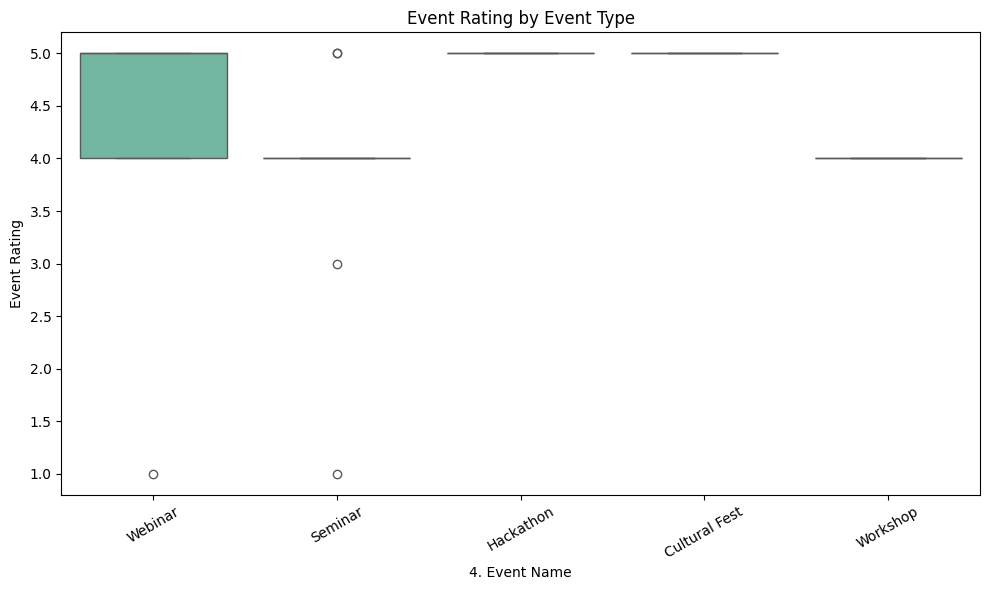

In [41]:
if '4. Event Name' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='4. Event Name', y='Event Rating', data=df, palette='Set2')
    plt.title("Event Rating by Event Type")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


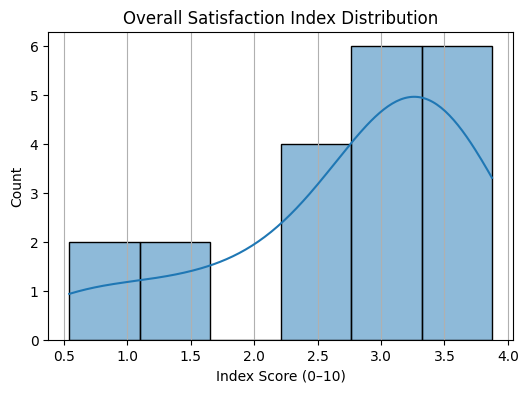

In [42]:
numeric_df['Satisfaction Index'] = numeric_df.mean(axis=1)

plt.figure(figsize=(6,4))
sns.histplot(numeric_df['Satisfaction Index'], kde=True)
plt.title("Overall Satisfaction Index Distribution")
plt.xlabel("Index Score (0–10)")
plt.grid(axis='x')
plt.show()


In [43]:
df.to_csv("Cleaned_Event_Feedback.csv", index=False)
